In [17]:
import pandas as pd
import numpy as np
import geopandas as gpd
import lightgbm
from shapely.geometry import shape
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score

In [18]:
df_train = pd.read_csv('data/train_dataset_train.csv').rename(columns={'.geo': 'geo'})
df_test = pd.read_csv('data/test_dataset_test.csv').rename(columns={'.geo': 'geo'})


In [19]:
nd_cols_raw = [col for col in df_train.columns if col.startswith('nd')]
nd_cols = pd.to_datetime([col[8:] for col in nd_cols_raw]).date
df_train = df_train.rename(columns={k: v for k, v in zip(nd_cols_raw, nd_cols)})
df_test = df_test.rename(columns={k: v for k, v in zip(nd_cols_raw, nd_cols)})

In [20]:
weeks = pd.date_range(nd_cols.min(), nd_cols.max(), freq='W').date
for i, week in enumerate(weeks):
    df_train[f'week_{i}_gain'] = df_train[nd_cols[nd_cols<week]].apply(max, axis=1)
    df_test[f'week_{i}_gain'] = df_test[nd_cols[nd_cols<week]].apply(max, axis=1)    

In [21]:
week_cols = [col for col in df_train.drop(nd_cols, axis=1).columns if col.startswith('week')]
df_train[week_cols] = df_train[week_cols].apply(lambda x: x - x.shift(), axis=1)
df_test[week_cols] = df_test[week_cols].apply(lambda x: x - x.shift(), axis=1)
df_train.drop('week_0_gain', axis=1, inplace=True)
df_test.drop('week_0_gain', axis=1, inplace=True)

In [22]:
# ИЗВЛЕКАЕТ КООРДИНАТЫ ЦЕНТРОИДА КАЖДОГО ПОЛИГОНА
def get_centroids(df):
    geom = [shape(i) for i in df.geo.apply(eval)]
    geo_df = gpd.GeoDataFrame(geometry=geom)
    centroid = geo_df.centroid
    area = geo_df.area
    df['centroid_x'] = centroid.x
    df['centroid_y'] = centroid.y
    df['area'] = area

In [24]:
get_centroids(df_train)
get_centroids(df_test)

In [25]:
X = df_train.drop(['geo', 'crop', 'id'], axis=1)
y = df_train.crop
df_test.drop(['geo', 'id'], axis=1, inplace=True)

In [27]:
params = {'objective': 'multiclass',
          'num_class': 7,
          'learning_rate': 0.065,
          'num_leaves': 1950,
          'max_depth': 8,
          'bagging_fraction': 0.95,
          'bagging_freq': 3,
          'feature_fraction': 0.7,
          'verbosity': -1}

In [28]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
CV_res = []
splits = {}
for counter, (trn_idx, tst_idx) in enumerate(kf.split(df_train)):
    X_train1, X_test1, y_train1, y_test1 = X.iloc[trn_idx], X.iloc[tst_idx], y.iloc[trn_idx], y.iloc[tst_idx]
    lgtrain, lgval = lightgbm.Dataset(X_train1, y_train1), lightgbm.Dataset(X_test1, y_test1)
    lgbmodel = lightgbm.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(0), lightgbm.early_stopping(100)])
    recall = recall_score(y_test1, lgbmodel.predict(X_test1).argmax(axis=1), average='macro', zero_division=True)
    CV_res.append(recall)
    splits[counter] = [trn_idx, tst_idx]
print('Recall scores:')
for i in CV_res: print(i)
print(f'Mean Recall: {np.mean(CV_res)}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.000249196	valid_1's multi_logloss: 0.0623385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00363903	valid_1's multi_logloss: 0.0832623
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.00028866	valid_1's multi_logloss: 0.0739794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.00170218	valid_1's multi_logloss: 0.0968639
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.000491388	valid_1's multi_logloss: 0.0635059
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's multi_loglo

In [29]:
trn_idx, tst_idx = splits[4]
X_train, X_test, y_train, y_test = X.iloc[trn_idx], X.iloc[tst_idx], y.iloc[trn_idx], y.iloc[tst_idx]

In [31]:
lgtrain, lgval = lightgbm.Dataset(X_train, y_train), lightgbm.Dataset(X_test, y_test)
lgbmodel = lightgbm.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(50), lightgbm.early_stopping(100)])
recall_score(y_test, lgbmodel.predict(X_test).argmax(axis=1), average='macro', zero_division=True)

Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 0.0367252	valid_1's multi_logloss: 0.1061
[100]	training's multi_logloss: 0.00170044	valid_1's multi_logloss: 0.0647193
[150]	training's multi_logloss: 9.17283e-05	valid_1's multi_logloss: 0.064046
[200]	training's multi_logloss: 1.05048e-05	valid_1's multi_logloss: 0.0702479
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.000491388	valid_1's multi_logloss: 0.0635059


0.9848472413427937

<AxesSubplot: >

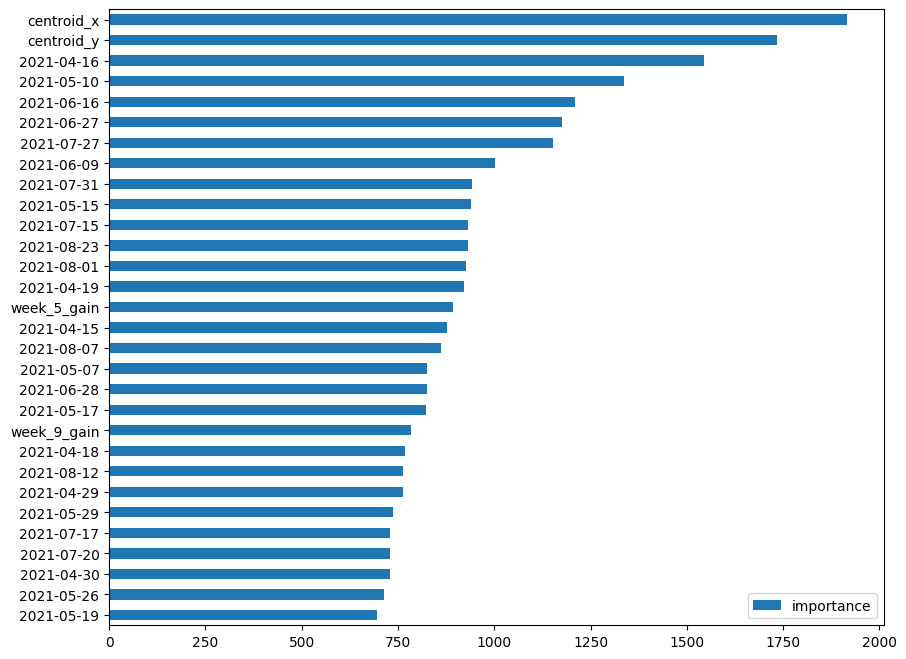

In [40]:
lgbm_feat = pd.DataFrame({'importance': lgbmodel.feature_importance()}, index=X.columns)
lgbm_feat.nlargest(30, columns='importance').sort_values(by='importance').plot(kind='barh', figsize=(10, 8
                                                                                                    ))

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pred = lgbmodel.predict(X_test).argmax(axis=1)

confusion = confusion_matrix(y_test, pred)
print('Confusion Matrix\n')
print(confusion)

print('\nClassification Report\n')
print(classification_report(y_test, pred, digits=4))

Confusion Matrix

[[77  0  0  0  2  0  1]
 [ 0 67  0  0  0  0  0]
 [ 0  0 74  0  1  0  1]
 [ 0  0  0 62  0  0  0]
 [ 2  0  0  0 68  0  1]
 [ 0  0  0  0  0 63  0]
 [ 0  0  0  0  0  0 64]]

Classification Report

              precision    recall  f1-score   support

           0     0.9747    0.9625    0.9686        80
           1     1.0000    1.0000    1.0000        67
           2     1.0000    0.9737    0.9867        76
           3     1.0000    1.0000    1.0000        62
           4     0.9577    0.9577    0.9577        71
           5     1.0000    1.0000    1.0000        63
           6     0.9552    1.0000    0.9771        64

    accuracy                         0.9834       483
   macro avg     0.9840    0.9848    0.9843       483
weighted avg     0.9837    0.9834    0.9834       483



## Pred

In [27]:
pred_df = pd.DataFrame(lgbmodel.predict(df_test).argmax(axis=1), columns=['crop'])
pred_df['id'] = pd.read_csv('data/sample_solution.csv').id
pred_df[['id', 'crop']].to_csv('data/submission_13.csv', index=False)

In [34]:
X.columns

Index([        'area',     2021-04-16,     2021-04-19,     2021-04-22,
           2021-04-26,     2021-04-28,     2021-05-02,     2021-05-04,
           2021-05-07,     2021-05-16,     2021-05-17,     2021-05-21,
           2021-05-26,     2021-05-27,     2021-05-29,     2021-06-06,
           2021-06-09,     2021-06-13,     2021-06-16,     2021-06-18,
           2021-06-19,     2021-06-20,     2021-06-22,     2021-06-25,
           2021-06-27,     2021-07-07,     2021-07-08,     2021-07-09,
           2021-07-13,     2021-07-15,     2021-07-17,     2021-07-20,
           2021-07-26,     2021-07-27,     2021-07-29,     2021-07-31,
           2021-08-07,     2021-08-12,     2021-04-15,     2021-04-18,
           2021-04-25,     2021-04-27,     2021-04-29,     2021-04-30,
           2021-06-07,     2021-06-12,     2021-06-28,     2021-08-01,
           2021-08-11,     2021-05-01,     2021-05-03,     2021-05-10,
           2021-05-15,     2021-06-02,     2021-06-03,     2021-07-04,
      